In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)
plt.style.use('ggplot')



#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

import seaborn as sns
import os
from tqdm import tqdm
from tqdm import tqdm_notebook
import missingno as msno
from scipy import stats
import gc
import warnings
warnings.filterwarnings("ignore")

#define helping function
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text

<IPython.core.display.Javascript object>

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [3]:
def make_pca(in_df, palette, ax, top=500):
    cols = in_df.columns
    pca = PCA(n_components=2)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    temp_df['color']=palette
    #fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=30, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [ax.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'),ax=ax)
    ax.set_title('PCA', size=14)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]),size=12)
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]),size=12)
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    

    
def make_mds(in_df, palette, ax, top=500):
    cols = in_df.columns
    pca = MDS(n_components=2,metric=True)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    temp_df = pd.DataFrame(pca.fit_transform(in_df.T),
                                 index=cols,columns =['pc_1','pc_2'] )
    
    temp_df['color']=palette
    
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=50, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [ax.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'),ax=ax)
    ax.set_title('MDS',size=14)
    ax.set_xlabel('DIM_1',size=12)
    ax.set_ylabel('DIM_2',size=12)
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)

    #plt.show()
    

def hist_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax.legend(handles=new_handles, labels=labels)


In [4]:
#add back the description of the proteins
desc_dict = {}
path = '../TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()#.replace('gene_product=','')
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc

In [5]:
#read data and log transform for plots
df = pd.read_csv('txt/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()
df_09=df.dropna(subset=['Protein IDs'],axis=0)

removed  44 Only identified by site
tot  44  entries removed
---------------
removed  29 Reverse
tot  73  entries removed
---------------
removed  27 Potential contaminant
tot  100  entries removed
---------------


In [6]:
#read data and log transform for plots
df = pd.read_csv('../20190318 TbPIGA/txt/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()
df_03=df.dropna(subset=['Protein IDs'],axis=0)

removed  87 Only identified by site
tot  87  entries removed
---------------
removed  25 Reverse
tot  112  entries removed
---------------
removed  64 Potential contaminant
tot  176  entries removed
---------------


After this, missing values were imputed with values representing a normal distribution around the detection limit of the mass spectrometer. To that end, mean and standard deviation of the distribution of the real intensities were determined, then a new distribution with a downshift of 1.8 standard deviations and a width of 0.25 standard deviations was created. 

In [7]:
def mod_df(df):
    df['Gene_id'] = [clean_id(n.split(':')[0].split(';')[0]) for n in df['Protein IDs']]
    df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
    df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
    df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() 
                                          if a in desc_dict else 'none' for a in n.split(';')]) 
                           for n in df['Gene_id_all' ]  ]  
mod_df(df_03)    
mod_df(df_09)   

In [8]:
col = 'iBAQ'
#def fold_change(df,col_1,col_2):
#    df['fc']= np.log2(df[col_1]/df[col_2])

#fold_change(df_03,col_1='iBAQ 2',col_2='iBAQ 1')
#fold_change(df_09,col_1='iBAQ 1',col_2='iBAQ 2')
merge = df_03[
    ['Gene_id',col+' 1',col+' 2']].merge(df_09[
    ['Gene_id',col+' 1',col+' 2']],left_on='Gene_id',
                                         right_on='Gene_id',
                                         how='outer',suffixes=('_03','_09'))
merge.set_index('Gene_id',inplace=True)
merge.corr()

,iBAQ 1_03,iBAQ 2_03,iBAQ 1_09,iBAQ 2_09
iBAQ 1_03,1.000000,0.366965,0.541603,0.428868
iBAQ 2_03,0.366965,1.000000,0.840001,0.817078
iBAQ 1_09,0.541603,0.840001,1.000000,0.932947
iBAQ 2_09,0.428868,0.817078,0.932947,1.000000


In [9]:
for n in merge.columns:
    merge[n] = merge[n].replace('NaN', np.nan)
    merge[n] = merge[n].fillna(0)

In [10]:
def impute(col,ax):
    temp = col.copy()
    random = temp.apply(lambda v: np.random.normal(temp[temp>0].min(), scale=temp[temp>0].min()*0.25))
    np.log10(random).plot(kind='hist',histtype='step', 
                          normed=True,ax=ax,label=col.name)
    col=col+random
    return col

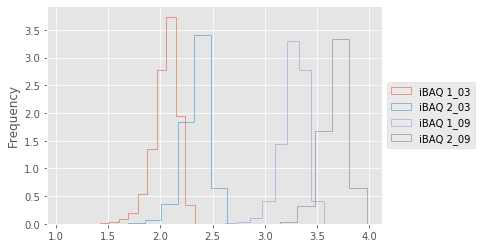

In [11]:
fig, ax = plt.subplots()
for n in merge.columns:
    merge[n] = impute(merge[n],ax=ax)

hist_legend(ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
merge.columns = ['E1','C1','C2','E2']
#merge = merge[['E1','E2','C1','C2']]

In [13]:
def norm_loading(df):
    col_sum = df.sum(axis=0)
    target = np.mean(col_sum)
    norm_facs = target / col_sum
    data_norm = df.multiply(norm_facs, axis=1)
    return  data_norm

data_norm = norm_loading(merge)

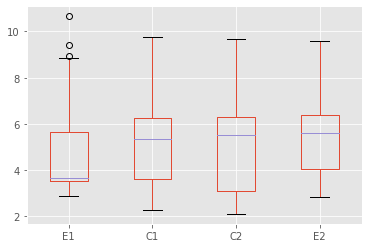

In [14]:
#data_irs = norm_loading(data_irs)
np.log10(data_norm).plot(kind='box')

In [15]:
#mean of the sum intensity of all the proteins in each channel
irs = pd.concat([data_norm[['E1','C1']].sum(axis=1), data_norm[['E2','C2']].sum(axis=1)], axis=1)
irs.columns = ["sum1", "sum2"]
#geometric mean of the sum intensity of all the proteins
irs['average']=np.exp(np.log(irs).mean(axis=1))
#normalization factors for each protein in each dataset
irs['fac1']=irs['average'] / irs['sum1']
irs['fac2']=irs['average'] / irs['sum2']

data_irs_1 = data_norm[['E1','C1']].multiply(irs.fac1, axis=0)
data_irs_2 = data_norm[['E2','C2']].multiply(irs.fac2, axis=0)
#combine again
data_irs = pd.concat([data_irs_1,data_irs_2],axis=1)
data_irs.head()

,E1,C1,E2,C2
Gene_id,,,,
Tb04.24M18.150,1.782065e+02,1.095902e+05,9.718712e+04,1.258128e+04
Tb927.5.4460,8.005803e+07,4.329211e+07,5.336396e+07,6.998618e+07
Tb927.5.4500,7.657436e+05,4.662274e+07,3.324733e+07,1.414116e+07
Tb927.5.4520,4.276092e+06,1.475890e+06,2.300161e+06,3.451822e+06
Tb927.5.4560,2.716879e+06,1.849082e+06,3.048732e+06,1.517229e+06


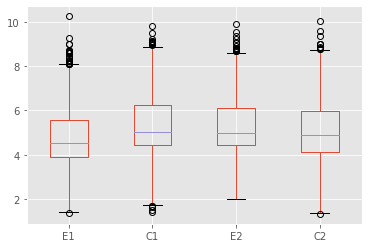

In [16]:
#data_irs = norm_loading(data_irs)
np.log10(data_irs).plot(kind='box')

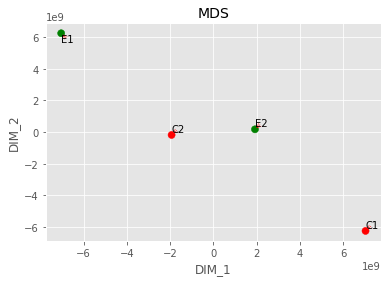

In [17]:
palette=['g','r','g','r']
fig, ax = plt.subplots()
make_mds(data_irs, palette, ax, top=500)

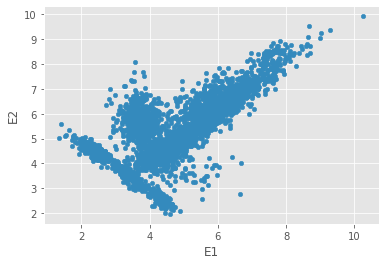

In [18]:
np.log10(data_irs).plot(kind='scatter',x='E1',y='E2')

In [19]:
from scipy.stats import ttest_ind



In [21]:
#prob

In [22]:
data_irs['mean_E']=data_irs[['E1','E2']].mean(axis=1)
data_irs['mean_C']=data_irs[['C1','C2']].mean(axis=1)
data_irs['log10Sum']=np.log10(data_irs[['E1','E2','C1','C2']].sum(axis=1))
data_irs['log2FC']=np.log2(data_irs['mean_E']/data_irs['mean_C'])
data_irs['desc']=[desc_dict[n] for n in data_irs.index.values]
data_irs['desc'] = [n.replace('gene_product=','') for n in data_irs['desc'] ]
data_irs['Log10signal_Q'] = pd.qcut(data_irs['log10Sum'], 50, range(50))
t, prob = ttest_ind(data_irs[['E1','E2']].values,data_irs[['C1','C2']].values,axis=1)
data_irs['t']=t
data_irs['prob']=prob
data_irs['-log10pvalue']=-np.log10(data_irs['prob'])

In [23]:
data_irs.head()

,E1,C1,E2,C2,mean_E,mean_C,log10Sum,log2FC,desc,Log10signal_Q,t,prob,-log10pvalue
Gene_id,,,,,,,,,,,,,
Tb04.24M18.150,1.782065e+02,1.095902e+05,9.718712e+04,1.258128e+04,4.868266e+04,6.108574e+04,5.341507,-0.327427,"hypothetical protein, conserved",20,-0.180814,0.873177,0.058898
Tb927.5.4460,8.005803e+07,4.329211e+07,5.336396e+07,6.998618e+07,6.671099e+07,5.663914e+07,8.392170,0.236125,"major vault protein, putative",48,0.533592,0.646985,0.189106
Tb927.5.4500,7.657436e+05,4.662274e+07,3.324733e+07,1.414116e+07,1.700654e+07,3.038195e+07,7.976703,-0.837125,"ras-like small GTPase, putative",47,-0.582351,0.619235,0.208145
Tb927.5.4520,4.276092e+06,1.475890e+06,2.300161e+06,3.451822e+06,3.288126e+06,2.463856e+06,7.060848,0.416348,Kinetochore interacting protein 1,41,0.589947,0.615000,0.211125
Tb927.5.4560,2.716879e+06,1.849082e+06,3.048732e+06,1.517229e+06,2.882806e+06,1.683155e+06,6.960562,0.776305,"guanine deaminase, putative",40,5.112392,0.036196,1.441339


In [24]:
ids = '''Tb927.10.6140
Tb927.5.3680
Tb927.10.10110
Tb927.3.4570
Tb927.4.780
Tb927.10.4610
Tb11.v5.0765'''.split('\n')

ids = data_irs.loc[ids]
print(ids.head())
_ids = ids.index.values
_names = [' '.join( n.split(' ')[0:2]) for n in ids['desc']]
print(len(_ids))
print(len(_names))

                         E1            C1           E2            C2  \
Gene_id                                                                
Tb927.10.6140   1975.559728  3.587113e+07  2431.359722  3.587068e+07   
Tb927.5.3680    1254.584206  1.917869e+08  6754.879504  1.917814e+08   
Tb927.10.10110  1923.165355  1.508880e+08  4374.291642  1.508855e+08   
Tb927.3.4570    3136.338536  1.833277e+07  2557.572801  1.833335e+07   
Tb927.4.780     1486.548317  6.797025e+06  8202.605976  6.790308e+06   

                     mean_E        mean_C  log10Sum     log2FC  \
Gene_id                                                          
Tb927.10.6140   2203.459725  3.587091e+07  7.855799 -13.990756   
Tb927.5.3680    4004.731855  1.917842e+08  8.583852 -15.547418   
Tb927.10.10110  3148.728498  1.508868e+08  8.479690 -15.548337   
Tb927.3.4570    2846.955669  1.833306e+07  7.564332 -12.652740   
Tb927.4.780     4844.577147  6.793667e+06  7.133444 -10.453604   

                                

In [27]:
#data_irs['fc_col'].plot(kind='hist')

(13, 13)


,E1,C1,E2,C2,mean_E,mean_C,log10Sum,log2FC,desc,Log10signal_Q,t,prob,-log10pvalue
Gene_id,,,,,,,,,,,,,
Tb927.10.6140,1975.559728,3.587113e+07,2431.359722,3.587068e+07,2203.459725,3.587091e+07,7.855799,-13.990756,phosphatidylinositolN- acetylglucosaminyltrans...,46,-111290.050814,8.073973e-11,10.092913
Tb11.v5.0765,1021.765176,3.143961e+08,7239.302390,3.143899e+08,4130.533783,3.143930e+08,8.798509,-16.215881,N-acetylglucosaminyl-phosphatidylinositol bios...,48,-71509.509439,1.955566e-10,9.708728
Tb927.10.10110,1923.165355,1.508880e+08,4374.291642,1.508855e+08,3148.728498,1.508868e+08,8.479690,-15.548337,"PIG-P, putative",48,-87054.531624,1.319524e-10,9.879583
Tb927.2.2460,3619.684184,2.468608e+06,2476.378683,2.469752e+06,3048.031434,2.469180e+06,6.694119,-9.661939,"ubiquitin-conjugating enzyme E2, putative",37,-3050.486043,1.074637e-07,6.968738
Tb927.3.2480,3113.136364,1.839447e+07,1946.606691,1.839563e+07,2529.871528,1.839505e+07,7.565791,-12.827966,"Arv1-like family, putative",45,-22297.717542,2.011311e-09,8.696521


In [36]:
def make_vulcano(df, ax, x='-Log10PValue', 
                 y='Log2FC',
                 fc_col = 'log2FC',
                 fc_limit=False,
                 
                 pval_col = 'PValue',
                 pval_limit=False,
                 
                 annot_index=pd.Series(), 
                 annot_names=pd.Series(),
                 title='Vulcano',
                  ):
    
    

    if fc_limit:
        upper = df[df[fc_col]>fc_limit].copy()
        lower = df[df[fc_col]<-fc_limit].copy()
        
    if pval_limit:
        upper = upper[upper[pval_col]>pval_limit].copy()
        lower = lower[lower[pval_col]<-pval_limit].copy()
    
   
    if 'upper' in locals() and upper.shape[0]>0:
        #print(upper.head())
        upper.plot(
        kind='scatter',x=x,y=y, ax=ax, 
        c='r', label='Up in Control',alpha=0.5)
   
    if 'lower' in locals() and lower.shape[0]>0:     
        lower.plot(
        kind='scatter',x=x,y=y, ax=ax, 
        c='g', label='Up in Bait',alpha=0.5)       
    
    
    df.plot(kind='scatter', x=x, y=y, ax=ax, alpha=0.2)
    

    
    ax.legend(loc='upper center', bbox_to_anchor=(0.85, -0.05))
    ax.set_title(title)
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    texts = [ax.text(df.loc[i][x], df.loc[i][y],name)
                       for i,name in zip(annot_index,annot_names)]

    adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                       color='red'),
                ax=ax)


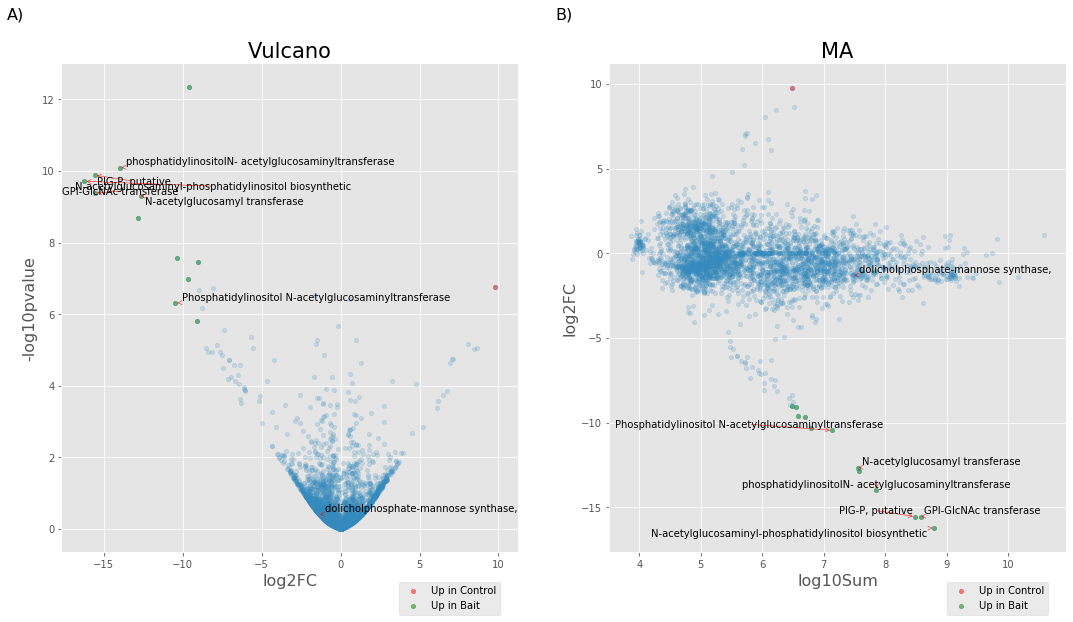

In [37]:
fig, axes=plt.subplots(figsize=(18,9), ncols=2, nrows=1)

make_vulcano(data_irs, axes[0], x='log2FC', y='-log10pvalue', 
             annot_index=_ids,
             annot_names = _names,
             title='Vulcano',
             fc_limit=9,
             fc_col='log2FC'
            )

make_vulcano(data_irs, axes[1], x='log10Sum', y='log2FC', 
             annot_index=_ids,
             annot_names = _names,
             title='MA',
              fc_col = 'log2FC',
                 fc_limit=9,
            )

#data_irs.groupby('Log10signal_Q')[['log10Sum','log2FC']].mean().plot(ax=axes[1],
#                                                                        x='log10Sum',
#                                                                        y='log2FC')

#axes[1].set_xlim(data_irs['log10Sum'].min()-data_irs['log10Sum'].min()*0.01,
#                 data_irs['log10Sum'].max()+data_irs['log10Sum'].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0].transAxes,fontsize=16)

axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)
#plt.tight_layout()
#plt.savefig(os.path.join(TXT_PATH,'Fig_2_cyclins.png'))
plt.show()

In [38]:
data_irs.to_csv('all_exp.csv')